In [26]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_predict, cross_val_score, RepeatedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler

In [27]:
df = pd.read_csv('../Base_Umbilo_Diaria.csv', sep=';',decimal=',')
df.set_index('Dia', inplace=True)

df

Q_entrada  NH_entrada  TSS_entrada  DQO_entrada  DBO_entrada  \
Dia                                                                   
0    4719.000000   21.000000   271.000000   391.000000   198.575000   
1    5866.458829   22.000327   276.000327   399.999347   203.059809   
2    5358.157069   23.998870   281.996233   406.995103   206.957307   
3    5266.313109   22.999791   278.000209   401.000418   203.710285   
4    6671.931586   21.000432   274.999568   396.999136   201.824410   
..           ...         ...          ...          ...          ...   
361  5587.915779   22.000000   182.001170   263.000000   134.093479   
362  5984.690649   22.998229   179.999646   259.000354   131.495253   
363  8328.225128   19.001002   177.000334   255.999332   129.609978   
364  5364.000000   18.000000   175.000000   251.000000   127.660000   
365  2334.275029   16.978515   172.957030   245.892574   125.668104   

     TN_entrada  TKN_entrada  TP_entrada  PO_entrada      Q_saida  NH_saida  \
Dia                                                                           
0     34.060000    34.060000    8.020000         4.6  6135.066621  3.854908   
1     35.360294    35.360294    8.099990         4.6  5636.285517  0.773286   
2     37.558734    37.558734    8.149966         4.6  5128.278103  0.572453   
3     36.399787    36.399787    8.109998         4.6  5036.211393  0.386242   
4     34.220441    34.220441    8.060004         4.6  6441.737326  0.376058   
..          ...          ...         ...         ...          ...       ...   
361   30.780012    30.780012    6.900000         4.6  5357.809665  0.229408   
362   31.668215    31.668215    6.869996         4.6  5754.451216  0.270272   
363   27.521002    27.521002    6.830000         4.6  8097.935230  0.336837   
364   26.370000    26.370000    6.790000         4.6  5134.741500  0.200074   
365   25.195292    25.195292    6.749141         4.6  2105.016529  0.100947   

      NO_saida  TSS_saida  DQO_saida  DBO_saida   TN_saida  TKN_saida  \
Dia                                                                     
0     0.079306   6.642565  83.782370   3.890641   5.042310   4.963005   
1     0.349220   5.766311  62.736147   2.720311   1.978541   1.629322   
2     0.692591   5.304955  55.605625   2.376578   2.021954   1.329363   
3     1.833623   4.898502  52.867768   2.081922   2.924917   1.091294   
4     4.070777   4.788757  51.670731   2.013649   5.128931   1.058154   
..         ...        ...        ...        ...        ...        ...   
361  20.738647   3.517159  35.116708   1.583500  21.428344   0.689698   
362  21.514507   3.509423  34.582476   1.606304  22.239991   0.725484   
363  19.448765   3.977019  34.977963   1.878834  20.261268   0.812503   
364  18.131642   3.398528  33.868320   1.663662  18.781715   0.650072   
365  19.066666   3.417396  33.183656   1.540150  19.608314   0.541648   

      TP_saida   PO_saida  
Dia                        
0     0.428499   0.326124  
1     9.226503   9.141557  
2    11.651663  11.575981  
3    12.464589  12.396924  
4    10.463329  10.398509  
..         ...        ...  
361   6.256764   6.209620  
362   5.447559   5.400288  
363   4.594725   4.540749  
364   4.667158   4.619641  
365   5.928673   5.881943  

[366 rows x 19 columns]

In [28]:
y = df['DQO_saida']
X = df.drop(['DQO_saida',
            'Q_saida',
            'NH_saida',
            'NO_saida',
            'TSS_saida',
            'DBO_saida',
            'TN_saida',
            'TKN_saida',
            'TP_saida',
            'PO_saida',
            'DBO_entrada',
            'DQO_entrada',
            'TKN_entrada',
            'TP_entrada',
            'PO_entrada'], axis=1)

print("X", X.shape)
print("y", y.shape)

X (366, 4)
y (366,)


In [29]:
seed = 42

# separando treino e teste
X_training, X_test, y_training, y_test = train_test_split(X, y, shuffle=False, test_size=0.082) 
print("Test set X", X_test.shape)
print("Test set y", y_test.shape)

Test set X (31, 4)
Test set y (31,)


In [30]:
# Padronização (Standardization) para o y
# Sempre usar os dados de treino apenas para construir o modelo, então transformar o teste com base no treino (como se o teste fossem dados novos)
y_train = np.array(y_training).reshape(len(y_training),1)
y_testing = np.array(y_test).reshape(len(y_test),1)

scalery = StandardScaler().fit(y_train)
normalized_y_train = pd.DataFrame(
    scalery.transform(y_train),
    columns = [y_training.name],
    index = y_training.index
)
normalized_y_train = normalized_y_train.squeeze()

normalized_y_test = pd.DataFrame(
    scalery.transform(y_testing),
    columns = [y_test.name],
    index = y_test.index
)
normalized_y_test = normalized_y_test.squeeze()


# Padronização dos previsores (DataFrame X)
scalerX = StandardScaler().fit(X_training)

normalized_x_train = pd.DataFrame(
    scalerX.transform(X_training),
    columns = X_training.columns,
    index = X_training.index
)


normalized_x_test = pd.DataFrame(
    scalerX.transform(X_test),
    columns = X_test.columns,
    index = X_test.index
)

In [31]:
# Random Forest com validação cruzada e Grid Search

# definindo os valores possíveis dos parâmetros a serem testados
params = {'n_estimators': [1,3,5,10,100],
          'max_depth': [2,3,5,10,15,20],
          'criterion': ['poisson','squared_error', 'absolute_error']
          }

# criando o objeto do modelo com RandomForestRegressor
rf_model_cv_gs = RandomForestRegressor(random_state = seed)

# criando o objeto do grid search com GridSearchCV
grid_search = GridSearchCV(rf_model_cv_gs, param_grid=params, return_train_score=True, scoring='neg_mean_absolute_percentage_error') #neg_root_mean_squared_error

# treinando o modelo com o grid search
grid_search.fit(normalized_x_train, normalized_y_train)

# pegando os resultados da validação cruzada (cv_results)
cv_results = pd.DataFrame(grid_search.cv_results_)

# pegando e imprimindo a melhor combinação de hiperparâmetros
cv_best_params = grid_search.best_params_
print('\n Best hyperparameters:')
print(cv_best_params)



 Best hyperparameters:
{'criterion': 'absolute_error', 'max_depth': 3, 'n_estimators': 3}


In [32]:
# imprimindo o score médio nas bases de treino
print("Average accuracy on train set: {:.3f} +/- {:.3f}".format(cv_results[cv_results.rank_test_score == 1].mean_train_score.values[0],
                                                                     cv_results[cv_results.rank_test_score == 1].std_train_score.values[0])) 
# imprimindo o score médio nas bases de validação
print("Average accuracy on test set: {:.3f} +/- {:.3f}".format(cv_results[cv_results.rank_test_score == 1].mean_test_score.values[0],
                                                                     cv_results[cv_results.rank_test_score == 1].std_test_score.values[0])) 

# configurando o modelo com a melhor combinação de hiperparâmetros
rf_model_cv_gs.set_params(n_estimators = cv_best_params['n_estimators'],
                        max_depth = cv_best_params['max_depth'],
                        )

# treinando um modelo com a melhor combinação de hiperparâmetros
rf_model_cv_gs.fit(normalized_x_train, normalized_y_train)
best_model_params = rf_model_cv_gs.get_params()

Average accuracy on train set: -1.405 +/- 0.210
Average accuracy on test set: -1.958 +/- 1.669


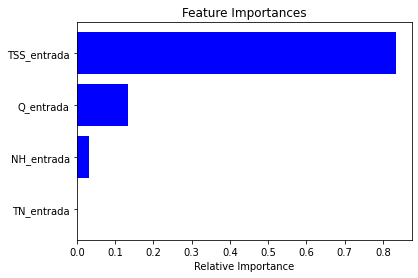

In [33]:
# desenhando o gráfico de impoartância de variáveis
features = normalized_x_train.columns
importances = rf_model_cv_gs.feature_importances_
indices = np.argsort(importances)

feature_importances_df = pd.DataFrame({'features': features,
                                       'importances': importances})

plt.title('Feature Importances')
plt.barh(range(len(importances[indices][-16:])), importances[indices][-16:], color='b', align='center')
plt.yticks(range(len(importances[indices][-16:])), [features[i] for i in indices[-16:]])
plt.xlabel('Relative Importance')
plt.show()

In [34]:
# Informações úteis sobre o melhor modelo
# print(importances)
# print(indices)
# print(importances[indices][-16:])
# print(sum(importances))

# Feature importance em DataFrame para ser mais consumível
df_importances = pd.DataFrame({'feature': features, 'importances': importances})
df_importances.sort_values(by='importances', ascending=False)

feature  importances
2  TSS_entrada     0.833680
0    Q_entrada     0.134324
1   NH_entrada     0.031996
3   TN_entrada     0.000000

In [35]:
# Cross-validation para averiguar precisão do modelo na base de treino
print('---------Treino---------')
results = cross_val_score(rf_model_cv_gs,X=normalized_x_train,y=normalized_y_train,cv=KFold(n_splits=10), scoring='neg_mean_absolute_percentage_error')*(-1)
print(results)
print('Média: {}\nStd: {}'.format(round(results.mean(),4),round(results.std(),4)))
print('---------Total---------')
# Predição analisada por validação cruzada para o dataset inteiro
results_total = cross_val_score(rf_model_cv_gs,X=X,y=y,cv=KFold(n_splits=10), scoring='neg_mean_absolute_percentage_error')*(-1)
print(results_total)
print('Média: {}\nStd: {}'.format(round(results_total.mean(),4),round(results_total.std(),4)))

---------Treino---------
[0.8143342  1.28913778 1.07679489 1.66752202 2.2418251  4.16459251
 1.84196787 2.01974081 0.73243645 1.82064955]
Média: 1.7669
Std: 0.9348
---------Total---------
[0.17017685 0.16634895 0.18384242 0.20653013 0.22727987 0.20743384
 0.11588521 0.16425231 0.21666711 0.26368984]
Média: 0.1922
Std: 0.039


In [36]:
# Realizando a predição no teste
y_test_pred_rf = rf_model_cv_gs.predict(normalized_x_test)

# Desnormalização
y_test_pred_rf = np.array(y_test_pred_rf).reshape(len(y_test_pred_rf),1)
y_test_pred_rf = scalery.inverse_transform(y_test_pred_rf)
y_test_pred_rf = pd.DataFrame(y_test_pred_rf, columns=[normalized_y_test.name], index = normalized_y_test.index)
y_test_pred_rf = y_test_pred_rf.squeeze()

y_test_pred_rf

# Análise dos erros das previsões
rmse_test_rf = math.sqrt(mean_squared_error(y_test, y_test_pred_rf))
mae_test_rf = mean_absolute_error(y_test, y_test_pred_rf)
mape_test_rf = mean_absolute_percentage_error(y_test, y_test_pred_rf)
r2_test_rf = r2_score(y_test, y_test_pred_rf)


df_metricas = pd.DataFrame(data={'RSME':[rmse_test_rf], 'MAE':[mae_test_rf], 'MAPE':[mape_test_rf],'R²':[r2_test_rf]})
df_metricas

RSME        MAE      MAPE        R²
0  16.847694  13.116813  0.272417  0.674495

In [37]:
# Preparação do DataFrame comparativo entre a previsão e o valor real, indexado pelo dia

df_comparacao = pd.concat([y_test,y_test_pred_rf],axis=1)
df_comparacao.columns = ['Valor_Real','Valor_Predito']
df_comparacao['Diferenca_percentual'] = 100*(df_comparacao['Valor_Predito'] - df_comparacao['Valor_Real'])/df_comparacao['Valor_Real']
df_comparacao.sort_index(inplace=True)
df_comparacao

Valor_Real  Valor_Predito  Diferenca_percentual
Dia                                                 
335   83.784619      82.065459             -2.051881
336   86.842041     105.655132             21.663575
337  119.987156     118.531667             -1.213037
338  138.940253     105.655132            -23.956428
339  126.281606     118.531667             -6.137029
340  112.852382     125.749617             11.428412
341  113.403341     125.749617             10.887048
342   94.146869      86.460896             -8.163811
343   86.724664     105.655132             21.828240
344   80.682729      82.065459              1.713787
345   81.205072      82.065459              1.059523
346   83.751125      82.065459             -2.012708
347   82.638915      82.065459             -0.693931
348   80.704829      88.379317              9.509329
349   75.640189      82.065459              8.494518
350   69.679649      62.078316            -10.908971
351   67.571221      65.990555             -2.339258
352   68.423722      82.065459             19.937144
353   66.871361      66.091192             -1.166671
354   62.369104      66.091192              5.967839
355   57.040046      66.091192             15.868055
356   51.301994      59.040104             15.083447
357   43.632757      59.040104             35.311422
358   38.710711      59.040104             52.516197
359   36.827353      65.218041             77.091306
360   35.834283      63.052979             75.957137
361   35.116708      63.052979             79.552647
362   34.582476      63.052979             82.326385
363   34.977963      59.040104             68.792288
364   33.868320      59.040104             74.322503
365   33.183656      65.218041             96.536633

        RSME        MAE      MAPE        R²
0  16.847694  13.116813  0.272417  0.674495


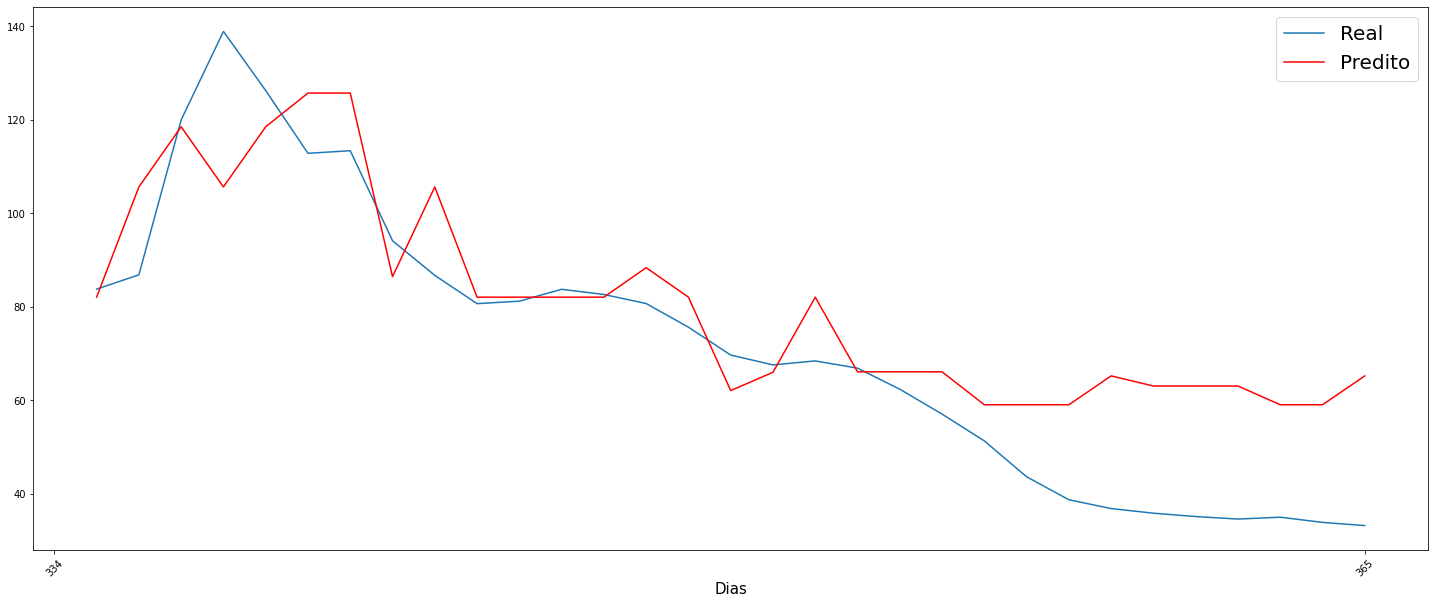

In [38]:
print(df_metricas)
import matplotlib.dates as mdates
# Visualização gráfica das predições comparadas aos valores reais
fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(1,1,1) 
# plt.title('', fontsize=25)
plt.plot(df_comparacao.index, df_comparacao['Valor_Real'], label = 'Real')
plt.plot(df_comparacao.index, df_comparacao['Valor_Predito'], label = 'Predito', c='r')
plt.legend(fontsize=20)
plt.xlabel('Dias', fontsize=15)
plt.xticks(fontsize=10, rotation=45)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1)) 
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%M-%d'))

plt.show()

In [39]:
df_comparacao.to_csv("1_1-Previsoes_RF.csv",encoding='utf-8-sig',sep=';',decimal=',')

# Previsão na base de treino

        RSME       MAE      MAPE        R²
0  23.302974  15.74412  0.150073  0.634393


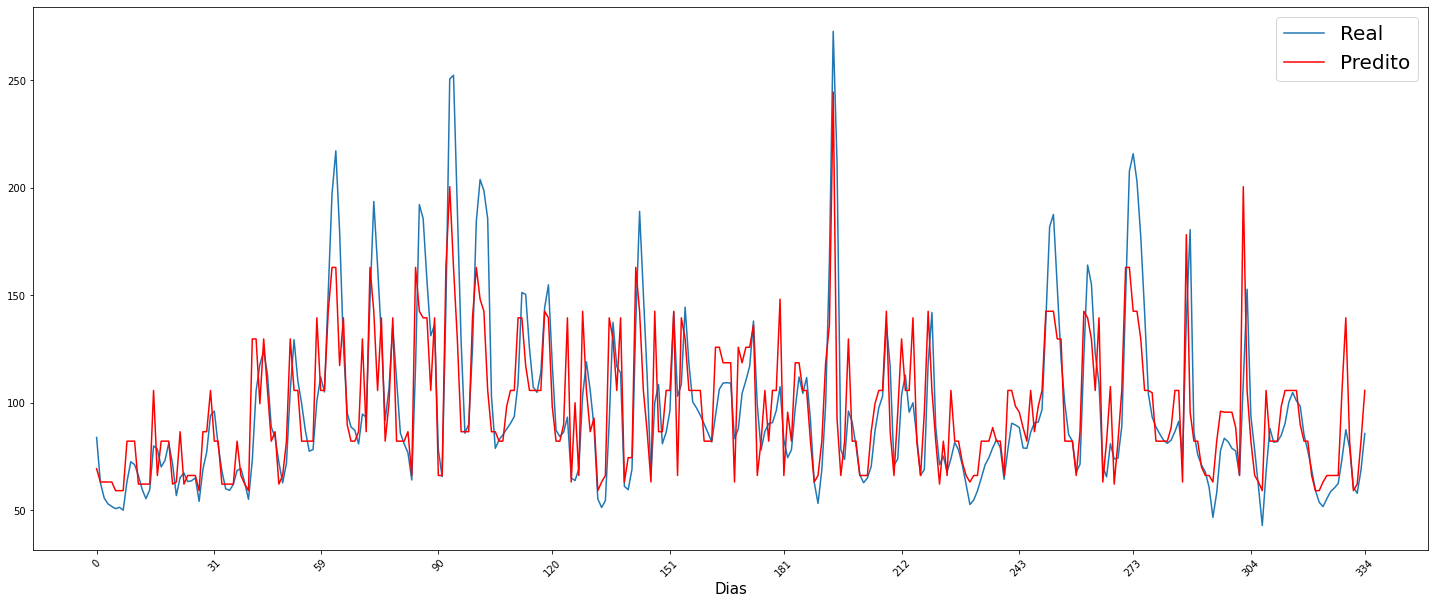

In [40]:
# Realizando a predição no traine
y_train_pred_rf = rf_model_cv_gs.predict(normalized_x_train)

# Desnormalização
y_train_pred_rf = np.array(y_train_pred_rf).reshape(len(y_train_pred_rf),1)
y_train_pred_rf = scalery.inverse_transform(y_train_pred_rf)
y_train_pred_rf = pd.DataFrame(y_train_pred_rf, columns=[normalized_y_train.name], index = normalized_y_train.index)
y_train_pred_rf = y_train_pred_rf.squeeze()

y_train_pred_rf


# Análise dos erros das previsões
rmse_train_rf = math.sqrt(mean_squared_error(y_train, y_train_pred_rf))
mae_train_rf = mean_absolute_error(y_train, y_train_pred_rf)
mape_train_rf = mean_absolute_percentage_error(y_train, y_train_pred_rf)
r2_train_rf = r2_score(y_train, y_train_pred_rf)

# Preparação do DataFrame comparativo entre a previsão e o valor real, indexado pelo dia
df_train_comparacao = pd.concat([y_training,y_train_pred_rf],axis=1)
df_train_comparacao.columns = ['Valor_Real','Valor_Predito']
df_train_comparacao['Diferenca_percentual'] = 100*(df_train_comparacao['Valor_Predito'] - df_train_comparacao['Valor_Real'])/df_train_comparacao['Valor_Real']
df_train_comparacao.sort_index(inplace=True)
df_train_comparacao


df_train_metricas = pd.DataFrame(data={'RSME':[rmse_train_rf], 'MAE':[mae_train_rf], 'MAPE':[mape_train_rf],'R²':[r2_train_rf]})
print(df_train_metricas)

# Visualização gráfica das predições comparadas aos valores reais
fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(1,1,1) 
# plt.title('', fontsize=25)
plt.plot(df_train_comparacao.index, df_train_comparacao['Valor_Real'], label = 'Real')
plt.plot(df_train_comparacao.index, df_train_comparacao['Valor_Predito'], label = 'Predito', c='r')
plt.legend(fontsize=20)
plt.xlabel('Dias', fontsize=15)
plt.xticks(fontsize=10, rotation=45)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1)) 
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%M-%d'))

plt.show()

In [41]:
# Gráfico de cima, queremos os dados só para o melhor modelo (base de treino)
df_train_comparacao.to_csv('2_1-Previsoes_TREINO_RF.csv',sep=';',decimal=',',encoding='utf-8-sig')

# FEATURE IMPORTANCE

## PDPs and Permutation Importance

In [42]:
print(normalized_x_train.min())
print(normalized_x_train.max())

Q_entrada     -2.727095
NH_entrada    -2.605314
TSS_entrada   -2.494750
TN_entrada    -2.588871
dtype: float64
Q_entrada      2.838441
NH_entrada     6.840331
TSS_entrada    4.629701
TN_entrada     4.368140
dtype: float64


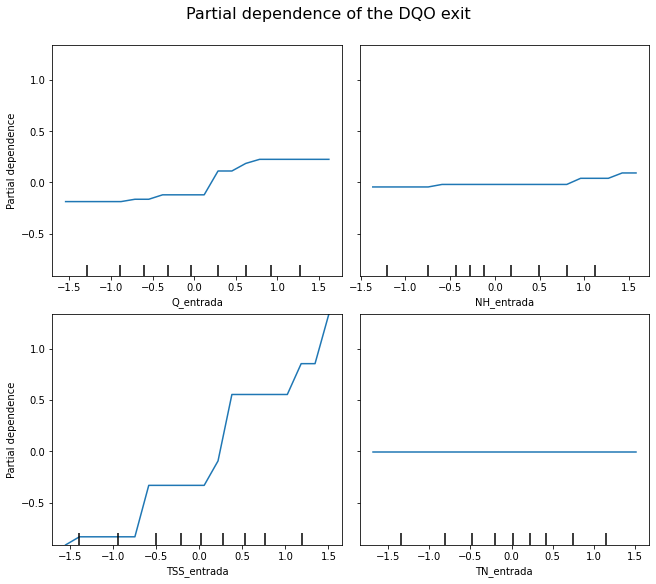

In [43]:
from sklearn.inspection import PartialDependenceDisplay

common_params = {
    "subsample": 50,
    "n_jobs": 2,
    "grid_resolution": 20,
    "random_state": 0,
}

# print("Computing partial dependence plots...")
features_info = {
    # features of interest
    "features": X_training.columns,
    # type of partial dependence plot
    "kind": "average",
    # information regarding categorical features
    # "categorical_features": categorical_features,
}

_, ax = plt.subplots(ncols=2, nrows=2, figsize=(9, 8), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    rf_model_cv_gs,
    normalized_x_train,
    **features_info,
    ax=ax,
    **common_params,
)

_ = display.figure_.suptitle(
    "Partial dependence of the DQO exit\n",
    fontsize=16,
)

Tree-based models provide an alternative measure of feature importances based on the mean decrease in impurity (MDI). Impurity is quantified by the splitting criterion of the decision trees (Gini, Log Loss or Mean Squared Error). However, this method can give high importance to features that may not be predictive on unseen data when the model is overfitting. Permutation-based feature importance, on the other hand, avoids this issue, since it can be computed on unseen data.Furthermore, impurity-based feature importance for trees are strongly biased and favor high cardinality features (typically numerical features) over low cardinality features such as binary features or categorical variables with a small number of possible categories.
Permutation-based feature importances do not exhibit such a bias. Additionally, the permutation feature importance may be computed performance metric on the model predictions and can be used to analyze any model class (not just tree-based models).

Importance_mean  Importance_std  Importance_mean_normalized
TSS_entrada         1.140320        0.115359                    0.871742
Q_entrada           0.148481        0.029190                    0.113510
NH_entrada          0.019292        0.008068                    0.014748
TN_entrada          0.000000        0.000000                    0.000000

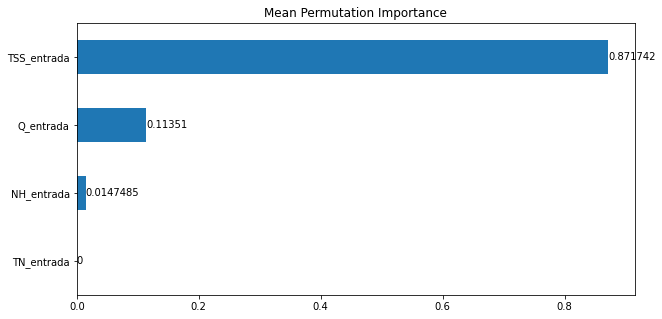

In [44]:
from sklearn.inspection import permutation_importance
r = permutation_importance(rf_model_cv_gs, normalized_x_train, normalized_y_train,
                           n_repeats=30,
                           random_state=0)
# r.importances_mean
# r.importances_std

df_permutation_importance = pd.DataFrame(
    data={'Importance_mean': r.importances_mean,
          'Importance_std': r.importances_std},
    index=normalized_x_train.columns
)

df_permutation_importance['Importance_mean_normalized'] = df_permutation_importance['Importance_mean']/df_permutation_importance['Importance_mean'].sum()

df_permutation_importance = df_permutation_importance.sort_values('Importance_mean',ascending=False)

ax = df_permutation_importance['Importance_mean_normalized'].sort_values(ascending=True).plot.barh(figsize=(10,5), title='Mean Permutation Importance')
ax.bar_label(ax.containers[0])

df_permutation_importance

In [45]:
df_permutation_importance.to_csv('3_1-Permutation_Importance_RF.csv',sep=';',decimal=',',encoding='utf-8-sig')

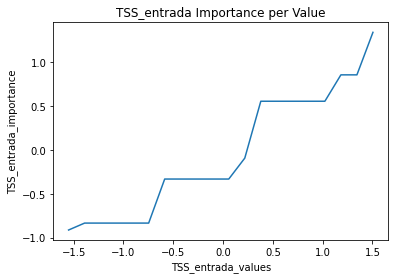

DBO_entrada_importance  Q_entrada_importance  Q_entrada_values  \
0                -0.186540             -0.186540         -1.545764   
1                -0.186540             -0.186540         -1.379149   
2                -0.186540             -0.186540         -1.212533   
3                -0.186540             -0.186540         -1.045917   
4                -0.186540             -0.186540         -0.879302   
5                -0.163780             -0.163780         -0.712686   
6                -0.163780             -0.163780         -0.546070   
7                -0.120525             -0.120525         -0.379454   
8                -0.120525             -0.120525         -0.212839   
9                -0.120525             -0.120525         -0.046223   
10               -0.120525             -0.120525          0.120393   
11                0.111711              0.111711          0.287008   
12                0.111711              0.111711          0.453624   
13                0.185482              0.185482          0.620240   
14                0.225315              0.225315          0.786855   
15                0.225315              0.225315          0.953471   
16                0.225315              0.225315          1.120087   
17                0.225315              0.225315          1.286702   
18                0.225315              0.225315          1.453318   
19                0.225315              0.225315          1.619934   

    NH_entrada_importance  NH_entrada_values  TSS_entrada_importance  \
0               -0.043828          -1.365209               -0.912526   
1               -0.043828          -1.210232               -0.833692   
2               -0.043828          -1.055255               -0.833692   
3               -0.043828          -0.900279               -0.833692   
4               -0.043828          -0.745302               -0.833692   
5               -0.019274          -0.590325               -0.833692   
6               -0.019274          -0.435349               -0.332362   
7               -0.019274          -0.280372               -0.332362   
8               -0.019274          -0.125395               -0.332362   
9               -0.019274           0.029582               -0.332362   
10              -0.019274           0.184558               -0.332362   
11              -0.019274           0.339535               -0.094097   
12              -0.019274           0.494512                0.553254   
13              -0.019274           0.649488                0.553254   
14              -0.019274           0.804465                0.553254   
15               0.040389           0.959442                0.553254   
16               0.040389           1.114418                0.553254   
17               0.040389           1.269395                0.853625   
18               0.092551           1.424372                0.853625   
19               0.092551           1.579348                1.337573   

    TSS_entrada_values  
0            -1.551337  
1            -1.390468  
2            -1.229599  
3            -1.068730  
4            -0.907861  
5            -0.746992  
6            -0.586123  
7            -0.425254  
8            -0.264385  
9            -0.103516  
10            0.057353  
11            0.218222  
12            0.379091  
13            0.539960  
14            0.700828  
15            0.861697  
16            1.022566  
17            1.183435  
18            1.344304  
19            1.505173

In [46]:
dict_data = {}
df_pdp = pd.DataFrame(display.pd_results[0]['average'].flatten(),columns=[X.columns[0]+'_importance'])
for i in range(len(display.pd_results)):
    dict_data[f"{X.columns[i]}_importance"] = display.pd_results[i]['average']
    dict_data[f"{X.columns[i]}_values"]  = display.pd_results[i]['values']
    # df_pdp[f"{X.columns[i]}_importance"] = dict_data[f"{X.columns[i]}_importance"].flatten()
    df_pdp[f"{X.columns[i]}_importance"] = display.pd_results[i]['average'][0]
    df_pdp[f"{X.columns[i]}_values"] = display.pd_results[i]['values'][0]


plt.plot(df_pdp.loc[:, 'TSS_entrada_values'], df_pdp.loc[:, 'TSS_entrada_importance'])
plt.xlabel('TSS_entrada_values')
plt.ylabel('TSS_entrada_importance')
plt.title('TSS_entrada Importance per Value')
plt.show()


df_pdp.to_csv('4_1-PDPs_RF.csv',encoding='utf-8-sig',decimal=',',sep=';')
df_pdp

In [47]:
# Avaliando na base de TESTE o impacto nas métricas causado pela permutação de valores de cada uma das variáveis.
# https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance
scoring = ['r2', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error']
r_multi = permutation_importance(
    rf_model_cv_gs, normalized_x_test, normalized_y_test, n_repeats=30, random_state=0, scoring=scoring)

# Apenas mostrar as variáveis cujas importâncias são maiores que 2 vezes o respectivo desvio padrão (para todas as métricas)
for metric in r_multi:
    print(f"{metric}")
    r1 = r_multi[metric]
    for i in r1.importances_mean.argsort()[::-1]:
        if r1.importances_mean[i] - 2 * r1.importances_std[i] > 0:
            print(f"    {X.columns[i]}: "
                  f"{r1.importances_mean[i]:.3f}"
                  f" +/- {r1.importances_std[i]:.3f}\n")

r2
    TSS_entrada: 1.381 +/- 0.313

neg_mean_absolute_percentage_error
    TSS_entrada: 0.773 +/- 0.185

    Q_entrada: 0.071 +/- 0.033

neg_mean_squared_error
    TSS_entrada: 0.811 +/- 0.184



In [48]:
# Avaliando na base de TREINO o impacto nas métricas causado pela permutação de valores de cada uma das variáveis.
# https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance
scoring = ['r2', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error'] #, 'neg_mean_absolute_error'
r_multi = permutation_importance(
    rf_model_cv_gs, normalized_x_train, normalized_y_train, n_repeats=30, random_state=0, scoring=scoring)

# Apenas mostrar as variáveis cujas importâncias são maiores que 2 vezes o respectivo desvio padrão (para todas as métricas)
for metric in r_multi:
    print(f"{metric}")
    r1 = r_multi[metric]
    for i in r1.importances_mean.argsort()[::-1]:
        if r1.importances_mean[i] - 2 * r1.importances_std[i] > 0:
            print(f"    {X.columns[i]}: "
                  f"{r1.importances_mean[i]:.3f}"
                  f" +/- {r1.importances_std[i]:.3f}")

r2
    TSS_entrada: 1.140 +/- 0.115
    Q_entrada: 0.148 +/- 0.029
    NH_entrada: 0.019 +/- 0.008
neg_mean_absolute_percentage_error
    TSS_entrada: 1.382 +/- 0.375
    Q_entrada: 0.792 +/- 0.393
neg_mean_squared_error
    TSS_entrada: 1.140 +/- 0.115
    Q_entrada: 0.148 +/- 0.029
    NH_entrada: 0.019 +/- 0.008


## LIME - Local Interpretable Model-Agnostic Explanations 

In [49]:
import lime
import lime.lime_tabular

# LIME has one explainer for all the models
explainer = lime.lime_tabular.LimeTabularExplainer(normalized_x_train.values, feature_names=X.columns.values.tolist(),
                                                  class_names=[y.name], verbose=True, mode='regression')

### Cálculo da importância de cada variável para um registro específico

In [50]:
# normalized_x_test.iloc[5]
# normalized_x_test.values[5]

# Choose the 5th instance and use it to predict the results
j = 5
exp = explainer.explain_instance(normalized_x_test.iloc[j], rf_model_cv_gs.predict, num_features=4)

# Show the predictions
exp.show_in_notebook(show_table=True)

exp.as_list()

Intercept -0.2248563390894308
Prediction_local [1.05604456]
Right: 0.7387208110761966


c:\Users\hydro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


[('TSS_entrada > 0.67', 1.411358179817235),
 ('Q_entrada <= -0.71', -0.2681487723087224),
 ('NH_entrada > 0.65', 0.16008374059663086),
 ('TN_entrada > 0.54', -0.022392250603926887)]

Interpretação: O valor Predito é o central da primeira imagem (Predicted value).
As variáveis à esquerda, tiveram influência negativa para o valor predito, enquanto que as variáveis à direita tiveram influência positiva.
Lista de Features com os respectivos valores alimentados para a previsão.

In [51]:
# Choose the 10th instance and use it to predict the results
j = 10
exp = explainer.explain_instance(normalized_x_test.iloc[j], rf_model_cv_gs.predict, num_features=6)

# Show the predictions
exp.show_in_notebook(show_table=True)

exp.as_list()

Intercept 0.056346152738878746
Prediction_local [0.22386967]
Right: -0.3947750089427459


c:\Users\hydro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


[('0.02 < TSS_entrada <= 0.67', 0.33257320033642584),
 ('-0.71 < Q_entrada <= -0.04', -0.11882261107384122),
 ('-0.59 < NH_entrada <= -0.12', -0.04709507727342873),
 ('-0.60 < TN_entrada <= 0.01', 0.0008680072644897493)]

In [52]:
# Choose the LAST instance and use it to predict the results
j = -1
exp = explainer.explain_instance(normalized_x_test.iloc[j], rf_model_cv_gs.predict, num_features=6)

# Show the predictions
exp.show_in_notebook(show_table=True)

exp.as_list()

Intercept 0.5301047011561574
Prediction_local [-1.13324019]
Right: -0.8319238162391794


c:\Users\hydro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


[('TSS_entrada <= -0.68', -1.2693483661540501),
 ('Q_entrada <= -0.71', -0.28991023040041725),
 ('NH_entrada <= -0.59', -0.0832520618668098),
 ('TN_entrada <= -0.60', -0.02083423609268114)]

In [53]:
# Apply lime to last 20 observations
from interpret.blackbox import LimeTabular
from interpret import show


# Initilize Lime for Tabular data
lime = LimeTabular(model=rf_model_cv_gs, 
                   data=normalized_x_train, 
                   random_state=1)
# Get local explanations
lime_local = lime.explain_local(normalized_x_test, 
                                normalized_y_test, 
                                name='LIME')

show(lime_local)

<!-- http://127.0.0.1:7001/1755997075728/ -->

### Análise de Feature Importance geral com LIME ao invés de apenas para ocorrência específica

In [54]:
import warnings
warnings.filterwarnings("ignore")

import re
l=[]
for n in range(0,normalized_x_test.shape[0]):
     exp = explainer.explain_instance(normalized_x_test.values[n], rf_model_cv_gs.predict, num_features=X.shape[1])
     a=exp.as_list()
     l.append(a)


df_lime_importances = pd.DataFrame()
for sublist in l:
    row_values = {}
    for condition, value in sublist:
        match = re.search(r'([a-zA-Z_]+)', condition)
        if match:
            text = match.group(1)        
            row_values[text] = value
    df_lime_importances = df_lime_importances.append(row_values, ignore_index=True)

df_lime_importances

Intercept 0.2886492751584434
Prediction_local [-0.47170393]
Right: -0.3947750089427459
Intercept -0.01709831411375355
Prediction_local [0.35870003]
Right: 0.2173186374831747
Intercept -0.21956405331956544
Prediction_local [1.03602199]
Right: 0.5514328711423727
Intercept -0.21307778414929482
Prediction_local [1.0180839]
Right: 0.2173186374831747
Intercept -0.2385260367277765
Prediction_local [1.09220496]
Right: 0.5514328711423727
Intercept -0.22129627487365963
Prediction_local [1.06782743]
Right: 0.7387208110761966
Intercept -0.21946751062382908
Prediction_local [1.0542714]
Right: 0.7387208110761966
Intercept 0.18215428449429621
Prediction_local [-0.14979887]
Right: -0.2807242867758604
Intercept 0.07989600077002937
Prediction_local [0.18118357]
Right: 0.2173186374831747
Intercept 0.23958485598557555
Prediction_local [-0.28696117]
Right: -0.3947750089427459
Intercept 0.03535668806917839
Prediction_local [0.20173873]
Right: -0.3947750089427459
Intercept 0.10059455140091918
Prediction_loca

TSS_entrada  Q_entrada  TN_entrada  NH_entrada
0     -0.523205  -0.251654    0.048756   -0.034251
1      0.352908  -0.158128    0.013965    0.167053
2      1.465490  -0.180133    0.008088   -0.037859
3      1.451512  -0.166045   -0.003775   -0.050530
4      1.419179  -0.292112    0.023042    0.180622
5      1.410787  -0.316653    0.010505    0.184485
6      1.418046  -0.298349    0.028603    0.125440
7     -0.542058   0.240572    0.019734   -0.050201
8      0.322843  -0.178571    0.002955   -0.045939
9     -0.551017   0.133756   -0.043709   -0.065577
10     0.349784  -0.163702   -0.001464   -0.018236
11     0.343222  -0.252440   -0.015599   -0.057163
12    -0.499460  -0.279286    0.000744    0.144660
13    -0.506402  -0.099821    0.006055    0.193609
14    -0.497904  -0.267829    0.032505    0.015181
15    -1.262413  -0.173202   -0.008636   -0.066730
16    -1.235326  -0.164232   -0.009944   -0.043697
17    -0.491344  -0.232018   -0.047236   -0.040877
18    -1.203814  -0.226012    0.000261   -0.013011
19    -1.236241  -0.216921   -0.028860    0.139460
20    -1.264318  -0.145246    0.022019    0.157237
21    -1.259993  -0.121285    0.024874   -0.053428
22    -1.223500  -0.227357    0.009753   -0.077431
23    -1.249499  -0.255378    0.031145   -0.071633
24    -1.251145  -0.252957   -0.065240   -0.101721
25    -1.266669  -0.255969    0.020517   -0.064276
26    -1.244447  -0.246210   -0.019477   -0.035679
27    -1.230885  -0.251910   -0.024039   -0.036824
28    -1.262744   0.134634   -0.016309   -0.076765
29    -1.242541  -0.242743    0.012851   -0.065134
30    -1.238865  -0.233289    0.035446   -0.045572

In [55]:
df_lime_absolute_importances = df_lime_importances.copy()

for i in range(df_lime_importances.shape[1]):
    df_lime_absolute_importances.iloc[:,i] = df_lime_absolute_importances.iloc[:,i].apply(lambda x: abs(float(x)))
     
df_lime_absolute_importances.head()

TSS_entrada  Q_entrada  TN_entrada  NH_entrada
0     0.523205   0.251654    0.048756    0.034251
1     0.352908   0.158128    0.013965    0.167053
2     1.465490   0.180133    0.008088    0.037859
3     1.451512   0.166045    0.003775    0.050530
4     1.419179   0.292112    0.023042    0.180622

In [56]:
df_lime_absolute_importances.mean()/df_lime_absolute_importances.mean().sum()

TSS_entrada    0.759570
Q_entrada      0.164112
TN_entrada     0.015678
NH_entrada     0.060639
dtype: float64

<Axes: >

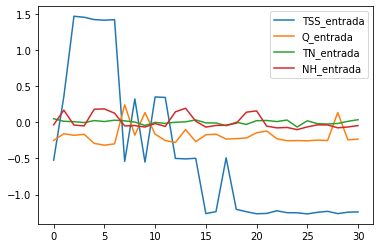

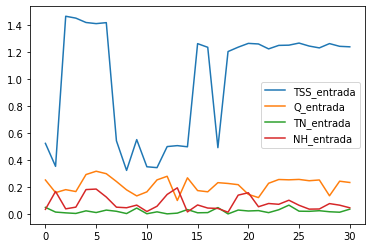

In [57]:
# df_lime_importances['TN'].plot()
df_lime_importances.plot()
df_lime_absolute_importances.plot()

### Análise de Feature Importance geral com LIME ao invés de apenas para ocorrência específica para a BASE DE TREINO

In [58]:
l=[]
for n in range(0,normalized_x_train.shape[0]):
     exp = explainer.explain_instance(normalized_x_train.values[n], rf_model_cv_gs.predict, num_features=X.shape[1])
     a=exp.as_list()
     l.append(a)


df_lime_train_importances = pd.DataFrame()
for sublist in l:
    row_values = {}
    for condition, value in sublist:
        match = re.search(r'([a-zA-Z_]+)', condition)
        if match:
            text = match.group(1)        
            row_values[text] = value
    df_lime_train_importances = df_lime_train_importances.append(row_values, ignore_index=True)

df_lime_train_importances

Intercept 0.49992591812543663
Prediction_local [-1.07491201]
Right: -0.7277996256891259
Intercept 0.46298733200905023
Prediction_local [-1.05676457]
Right: -0.8881018137505601
Intercept 0.48099606732834227
Prediction_local [-1.06397586]
Right: -0.8881018137505601
Intercept 0.4743244786325297
Prediction_local [-1.06574614]
Right: -0.8881018137505601
Intercept 0.4925067643559562
Prediction_local [-1.07898296]
Right: -0.8881018137505601
Intercept 0.4545296322607023
Prediction_local [-1.04457509]
Right: -0.9922260043006136
Intercept 0.37836824601679686
Prediction_local [-0.71254317]
Right: -0.9922260043006136
Intercept 0.4458860874163958
Prediction_local [-0.98038929]
Right: -0.9922260043006136
Intercept 0.30090043817566164
Prediction_local [-0.54195637]
Right: -0.3947750089427459
Intercept 0.3163457122503859
Prediction_local [-0.54888601]
Right: -0.3947750089427459
Intercept 0.465101116646735
Prediction_local [-1.05884897]
Right: -0.3947750089427459
Intercept 0.4751563157298145
Prediction

TSS_entrada  Q_entrada  NH_entrada  TN_entrada
0      -1.253697  -0.269737   -0.054422    0.003018
1      -1.220160  -0.231549   -0.044539   -0.023503
2      -1.240515  -0.265059   -0.030648   -0.008750
3      -1.242228  -0.268488   -0.032497    0.003143
4      -1.244708  -0.244070   -0.067030   -0.015683
..           ...        ...         ...         ...
330    -0.563284   0.182275   -0.046241   -0.012247
331    -1.251393  -0.095271   -0.094181   -0.005415
332    -1.219004  -0.265731   -0.090922    0.000464
333    -0.516841  -0.255179   -0.047148    0.010613
334     1.425992  -0.190706   -0.063264   -0.029559

[335 rows x 4 columns]

In [59]:
df_lime_train_absolute_importances = df_lime_train_importances.copy()

for i in range(df_lime_importances.shape[1]):
    df_lime_train_absolute_importances.iloc[:,i] = df_lime_train_absolute_importances.iloc[:,i].apply(lambda x: abs(float(x)))
     
df_lime_train_absolute_importances

TSS_entrada  Q_entrada  NH_entrada  TN_entrada
0       1.253697   0.269737    0.054422    0.003018
1       1.220160   0.231549    0.044539    0.023503
2       1.240515   0.265059    0.030648    0.008750
3       1.242228   0.268488    0.032497    0.003143
4       1.244708   0.244070    0.067030    0.015683
..           ...        ...         ...         ...
330     0.563284   0.182275    0.046241    0.012247
331     1.251393   0.095271    0.094181    0.005415
332     1.219004   0.265731    0.090922    0.000464
333     0.516841   0.255179    0.047148    0.010613
334     1.425992   0.190706    0.063264    0.029559

[335 rows x 4 columns]

In [60]:
df_lime_train_absolute_importances.mean()/df_lime_train_absolute_importances.mean().sum()

TSS_entrada    0.741043
Q_entrada      0.176912
NH_entrada     0.066399
TN_entrada     0.015646
dtype: float64

<Axes: >

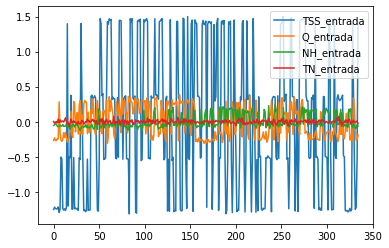

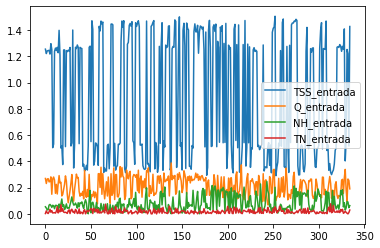

In [61]:
# df_lime_train_importances['TN'].plot()
df_lime_train_importances.plot()
df_lime_train_absolute_importances.plot()

In [62]:
# Saving predictions

# df_comparacao.to_csv("Previsoes_RF.csv", encoding='utf-8-sig',sep=';',decimal=',')